This is my solution for the skill test

In [1]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

os.sys.path.append('./..')
from utils.loadgenius import DataLoader
from utils.pretty import pprint, plot_missing_values, plot_value_counts
from utils.consignee_extract import parse_string_to_dict
from utils.country_name_detect import get_model

# Pointing the loader to the data loading instruction
dl = DataLoader('./../catalog.yml')

pprint(f"""Available dataset: \\
       {dl.list_datasets()}""")

Available dataset: \
       ['importer_normalized_data', 'main', 'ports', 'importers_cleaned', 'ports_cleaned', 'main_cleaned']

In [2]:
%%time
# Loading in datasets
ports = dl.load('ports').drop('Unnamed: 0', axis=1)
main = dl.load('main').drop('Unnamed: 0', axis=1)
importer = dl.load('importer_normalized_data').drop('Unnamed: 0', axis=1)

CPU times: user 21.7 s, sys: 789 ms, total: 22.5 s
Wall time: 22.6 s


# Preprocessing datasets

# `importer_normalized_data.csv`: duplicated raw names

In [3]:
pprint("Some raw names are duplicated")
report = importer["importer_raw_name"].value_counts()
display(report[report > 1])

Some raw names are duplicated

importer_raw_name
MASONITE LAWRENCEVILLE DFS         2
ANATOLIA TILE & STONE, INC. 202    2
MASONITE LAWRENCEVILLE             2
SINTEX MINERALS                    2
METSO MINERALS WAUKESHA            2
Name: count, dtype: int64

Duplication example MASONITE LAWRENCEVILLE DFS:

In [4]:
importer.query('importer_raw_name=="MASONITE LAWRENCEVILLE DFS"')

,importer_rank,importer_raw_name,importer_deduped_name
21480,3354,MASONITE LAWRENCEVILLE DFS,MASONITE CORP
46134,9981,MASONITE LAWRENCEVILLE DFS,MASONITE LAWRENCEVILLE DFS


**Resolve:** Keep the row with highest rank 

In [5]:
importer = importer.sort_values('importer_rank').drop_duplicates(subset=['importer_raw_name'], keep='first')

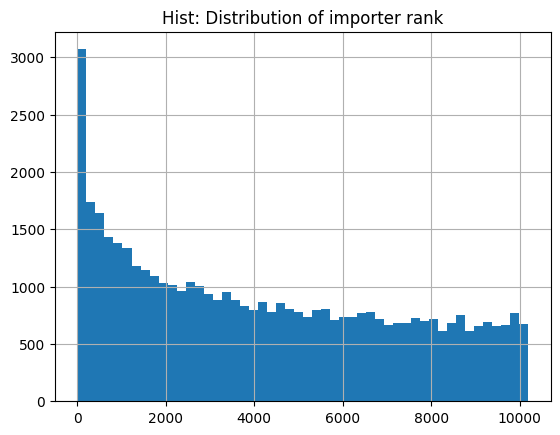

In [6]:
importer['importer_rank'].hist(bins=50)
plt.title("Hist: Distribution of importer rank");

It shows that above 5000, the distribution of ranks seems to be uniform.

## `ports.csv`: remove duplicates

In [7]:
print("ports: Rows before", ports.shape[0])
ports = (ports
         .drop_duplicates(subset=['port_code'])
         .reset_index(drop=True)
        )
print("ports: Rows after deduplication", ports.shape[0])

ports: Rows before 10927
ports: Rows after deduplication 2862


We only care about ports in `main.csv`:

Number of ports of interest = 97

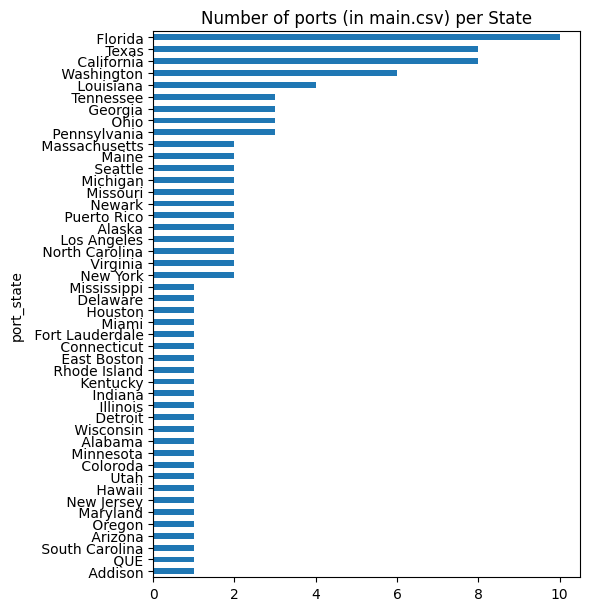

In [8]:
ports = ports[ports['port_code'].isin(set(main['port_of_unlading']))]
ports['port_state'] = ports['port_name'].str.split(',').apply(lambda x: x[1])
pprint(f"Number of ports of interest = {ports.shape[0]}")
ports['port_state'].value_counts()[::-1].plot.barh(figsize=(6, 6))
plt.tight_layout()
plt.title("Number of ports (in main.csv) per State");

## `main.csv`: extract important fields & drop duplicates

In [9]:
%%time
import multiprocessing as mp

original_columns = main.columns

with mp.Pool() as pool:
    result = pool.map(parse_string_to_dict, main['consignee'])
    
main['extracted'] = result
del(result)

CPU times: user 36.4 s, sys: 7.24 s, total: 43.7 s
Wall time: 1min 5s


In [10]:
# Double check if the extraction fails on any record
if any(main['extracted'].isna()):
    pprint("Extraction failed somewhere")
else:
    pprint("Extraction is successful")
    

Extraction is successful

Extract further on `cleaned_address_breakdown`

In [11]:
%%time
# Extract information in cleaned address
address_bits = ['address_number',
                 'country_name',
                 'place_name',
                 'state_name',
                 'street_name',
                 'street_name_post_type',
                 'street_name_pre_directional',
                 'street_name_pre_type',
                 'zip_code']

for bit in address_bits:
    main[bit] = main['extracted'].apply(lambda x: x['cleaned_address_breakdown'].get(bit, '')).replace('', pd.NA)
    print(f"Processing {bit}", end='\r')
    
main['id'] = main['extracted'].apply(lambda x: x['id'])
main['importer_raw_name'] = main['extracted'].apply(lambda x: x['name']).str.upper()

CPU times: user 21.6 s, sys: 258 ms, total: 21.8 s
Wall time: 21.9 s


Since we only care about names that exists in importer list:

In [12]:
# Make sure we don't join with duplicated table(s)
assert importer['importer_raw_name'].nunique() == importer.shape[0], "Cannot use importer column for joining"

importer['importer_raw_name'] = importer['importer_raw_name'].str.upper()
main = main.merge(importer, how='inner', on='importer_raw_name')

We want to check the number of nulls in each column:

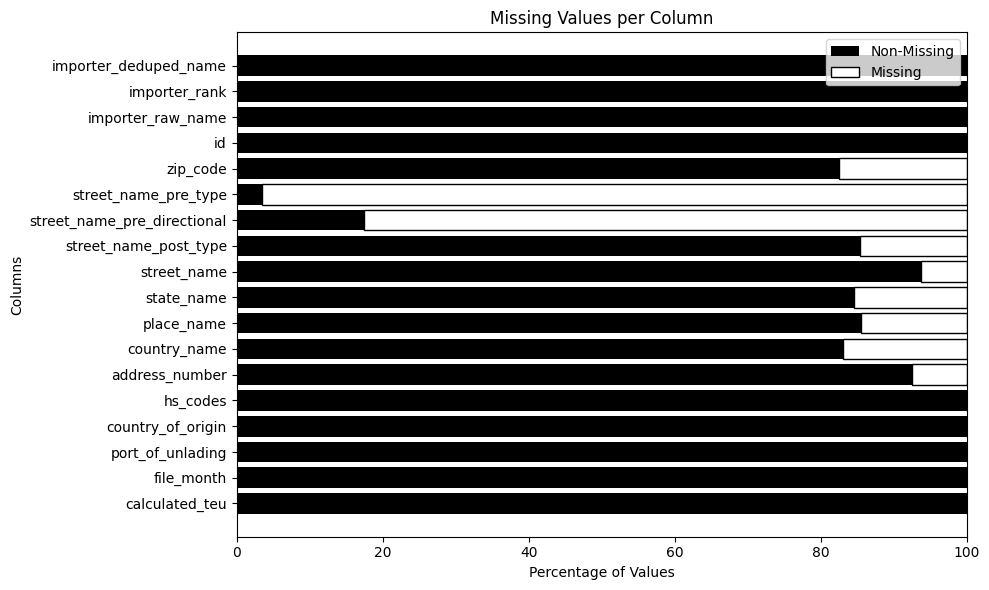

In [13]:
plot_missing_values(main.drop(["consignee", "extracted"],
                              axis=1),
                    as_percentage=True
                   )

### Observation 1: missing counts
`street_name_pre_type` and `street_name_pre_directional` have very high missing counts (approx 96% and 80% respectively)

### Observation 3: Imperfection of the cleaning method [OPTIONAL]

`cleaned_address_breakdown` seems to be a result by another extraction procedure.
This extraction is not perfect, as shown  in the graph of top 10 countries by frequencies in `main.csv`: sometimes it excludes STATES from UNITED STATES, yielding UNITED (which is a mistake)

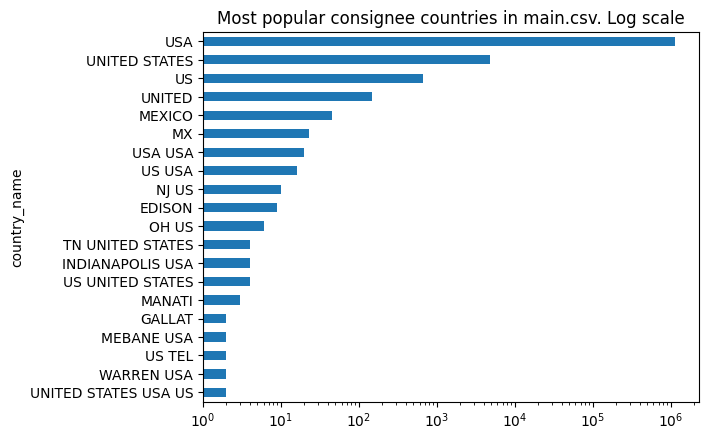

In [14]:
fig, ax = plt.subplots()
main['country_name'].value_counts().head(20)[::-1].plot.barh(log=True, ax=ax);
ax.set_title("Most popular consignee countries in main.csv. Log scale")
plt.show()

In [15]:
pprint("An example where UNITED STATES became UNITED after *cleaned*:")
pprint(main[main['country_name']=='UNITED']['consignee'].iloc[9])

An example where UNITED STATES became UNITED after *cleaned*:

{name=DAVID PEYSER SPORTSWEAR INC., address=90 SPENCE STREET, BAYSHORE, N.Y.11706, UNITED STATES., cleaned_address=90 SPENCE STREET, UNITED, cleaned_address_breakdown={address_number=90, country_name=UNITED, place_name=, state_name=, street_name=SPENCE, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=}, contact_name=, comm_number_qualifier=, comm_number=, id=9172da5f709b1914663d3b0e68f0243f}

In addition, sometimes the state name or another territory name gets in the `country_name`: NY in NY USA for instance.

Finally, synonyms were not handled at all: UNITED STATES, USA, US, USA US are the same thing.

Imperfection of the extraction on the country name level is a strong reason to assume the same happening in lower levels.

**How to fix that?** Use a better extraction method, such as Named Entity Recognition. For instance:

#### Demo Named-Entity-Recognition [OPTIONAL]

In [16]:
from spacy import displacy
    
nlp = get_model() # Retrieve an example NER model for country name detection

# Get some example consignee strings
samples_others = list(main[main['country_name'].str.lower().str.contains('serbia|taiwan') == True]['consignee'])[:2]
samples_us = list(main[main['country_name'].str.lower().str.contains('usa|united state| us') == True]['consignee'])[:1]

pprint("Showing an alternative way to extract country name:")
for example in samples_others + samples_us:
    displacy.render(
        nlp(example),
        style='ent')
    print("="*20)

Showing an alternative way to extract country name:

In the example above, my model is able to detect both US and UNITED STATES as the synonyms for USA.

Since developing such as model requires gathering  more country names and synonyms, I only show an example for a small number of countries as above.

### Observation 2: duplicated rows

Many rows in `main.csv` are exactly the same. **Possible reasons:**
- someone made a join with another duplicated dataframe ealier, resulting in duplicates in `main.csv`
- there's a missing column, which can be a key by itself or part of a composite key.

In [17]:
pd.set_option('display.max_colwidth', None)
pprint("Example of duplicated rows")
(
    main
    .query('id=="857a923157f99f7c13920a7e563ae9b2" & hs_codes=="HS CODE 8708 0000" & file_month==10')
    .sort_values('consignee')
    .head(3)[original_columns]
)

Example of duplicated rows

,consignee,calculated_teu,file_month,port_of_unlading,country_of_origin,hs_codes
1189926,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000
1199815,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000
1199816,"{name=DETROIT DIESEL PARTS DISTRIBUTION, address=CENTER 515 11TH STREET SE CANTON, OH 44707, cleaned_address=515 11TH STREET, CANTON, OH 44707, USA, cleaned_address_breakdown={address_number=515, country_name=USA, place_name=CANTON, state_name=OH, street_name=11TH, street_name_post_type=STREET, street_name_pre_directional=, street_name_pre_type=, zip_code=44707}, contact_name=, comm_number_qualifier=, comm_number=, id=857a923157f99f7c13920a7e563ae9b2}",2.0,10,1401,FRANCE,HS CODE 8708 0000


**Assuming this duplication is an error** (likely caused by join with duplicated data), I drop the duplicates:

In [18]:
before = main.shape[0]
pprint(f"`main.csv`: Number of rows before = {before}")

main = (main
        .drop_duplicates(subset=original_columns)
        .reset_index(drop=True)
       )

pprint(f"`main.csv`: Number of rows after drop_duplicates = {main.shape[0]}")
pprint(f"Drop rate = {round(100*(1- main.shape[0]/before))}%")

`main.csv`: Number of rows before = 1385308

`main.csv`: Number of rows after drop_duplicates = 531578

Drop rate = 62%

### HS codes mapping

In this subsection, I convert the first 4 digits in HS codes to their description (Chapter and Heading)

I do this to achieve a medium level of granularity for analysis and ML later

Implementation details:

- I used an opensource database [here](https://github.com/datasets/harmonized-system/tree/master) to lookup the hs codes
- To speed-up, I search for **unique hs codes** before mapping, rather than mapping straight away

In [19]:
hs_table = pd.read_csv('https://raw.githubusercontent.com/datasets/harmonized-system/master/data/harmonized-system.csv', dtype='str')

main['hs_codes_shorten'] = main['hs_codes'].str.replace(r'(\D)', '', regex=True).apply(lambda x: x[:4])

def query_hs_codes_desc(code, table):
    result = table.query("hscode==@code")['description']
    if result.shape[0] == 0:
        return None
    else:
        return list(result)[0]

hs_mapping = main[['hs_codes_shorten']].drop_duplicates().reset_index(drop=True)
hs_mapping['desc'] = hs_mapping['hs_codes_shorten'].apply(
    lambda x: query_hs_codes_desc(x, hs_table)
)

hs_mapping = hs_mapping.set_index('hs_codes_shorten')['desc']
hs_mapping = hs_mapping.to_dict()
main['hs_codes_desc'] = main['hs_codes_shorten'].apply(lambda x: hs_mapping[x])

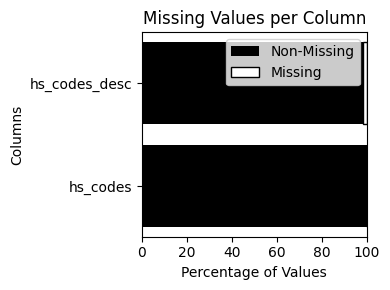

In [20]:
plot_missing_values(main[['hs_codes', "hs_codes_desc"]], as_percentage=True, figsize=(4,3))

In [21]:
unk = main[main['hs_codes_desc'].isna()]
pprint(f"Number of `hs_codes` values whose description cannot be found = {unk.shape[0]} ~ {round(unk.shape[0]/main.shape[0] * 100, 2)}%")
pprint("Examples and their frequencies")
display(unk['hs_codes'].value_counts().head())
del(unk)

Number of `hs_codes` values whose description cannot be found = 9775 ~ 1.84%

Examples and their frequencies

hs_codes
HS CODE 0000 0000    140
HS CODE 2167 0000    116
HS CODE 8803 3000    100
HS CODE 1000 0000     96
HS CODE 6011 0000     71
Name: count, dtype: int64

Within the timeframe of this skill test, I simply ignore the unknown hs codes for now.

# Only cares about row in main that can map to ports



In [22]:
copy = main[main['port_of_unlading'].isin(set(ports['port_code']))]
print(f"Before dropping rows with unknown ports: rows = {main.shape[0]}")
print(f"After dropping rows with unknown ports:  rows = {copy.shape[0]}")

Before dropping rows with unknown ports: rows = 531578
After dropping rows with unknown ports:  rows = 531578


No row is dropped (which is good)

In [23]:
# Saving datasets
main[['id', 'importer_deduped_name', 'importer_rank', 'zip_code', 'state_name',
      'hs_codes_shorten', 'hs_codes_desc', 'country_of_origin',
      'port_of_unlading', 'file_month', 'calculated_teu']].to_parquet("../datasets/main.parquet")

main[["id", "importer_deduped_name", "importer_rank"]].drop_duplicates().to_parquet("../datasets/importers.parquet")

ports.drop_duplicates().to_parquet("../datasets/ports.parquet")

# Analytics plan

To find out which company is worth investing, we care about the following things:
- What they import
- How frequent they import that product and how much, compared to other importer
- How much (in teu) they import that product, compared to the norm
- How diverse are their imports: Diversing but small company might be a redflag. A focused portfolio is always a good sign.
- Do they diversify their sources? How many ports of unloading? Higher can be an implication of scaled logistics activity. 
- ... PCA then clustering. Check if importers with higher rank cluster

In [22]:
def generate_sample_history(query=None):
    if query is None:
        sample_importer = list(main['id'].drop_duplicates().sample(1))[0]
    else:
        sample_importer = list(main.query(query)['id'].drop_duplicates().sample(1))[0]
    print(sample_importer)
    sample_history = main[main["id"]==sample_importer]
    return (
        sample_history[['file_month', 'hs_codes', 'calculated_teu',
                        'country_of_origin', 'port_of_unlading', 
                        'importer_deduped_name', 'importer_rank']].sort_values(
        ['file_month', 'hs_codes']
        )
        )


In [23]:
importer[['importer_rank', 'importer_deduped_name']].drop_duplicates().head(10)

,importer_rank,importer_deduped_name
0,1,DOLE FRESH FRUIT COMPANY
51,2,SAMSUNG ELECTRONICS AMERICA INC
137,4,LG ELECTRONICS
182,5,CHIQUITA FRESH NORTH AMERICA
250,6,IKEA
286,7,WALMART INC
304,11,DEL MONTE FRESH PRODUCE COMPANY
319,13,RED BULL GMBH
329,14,LG SOURCING INC
389,16,ANHEUSER-BUSCH COMPANIES LLC


In [24]:
generate_sample_history('importer_rank > 10000')

900a0cd44e934d9163184950ee890a70


,file_month,hs_codes,calculated_teu,country_of_origin,port_of_unlading,importer_deduped_name,importer_rank
1307470,2,HS CODE 7324 1000,1.0,VIETNAM,2709,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307472,2,HS CODE 7324 1000,2.0,VIETNAM,1703,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307468,6,HS CODE 7324 1000,1.0,VIETNAM,2704,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307475,7,HS CODE 7324 1000,1.0,VIETNAM,1703,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307469,8,HS CODE 7324 1000,2.0,VIETNAM,1703,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307471,8,HS CODE 7324 1000,1.0,VIETNAM,2704,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307478,8,HS CODE 7324 1000,2.0,VIETNAM,2704,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307474,9,HS CODE 7324 1000,2.0,VIETNAM,1703,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307477,9,HS CODE 7324 1000,2.0,VIETNAM,4601,CHEMCORE INDUSTRIES OF GEORGIA,10073
1307479,9,HS CODE 7324 1000,2.0,VIETNAM,2704,CHEMCORE INDUSTRIES OF GEORGIA,10073


In [25]:
importer_activity = (
    main[['id', 'hs_codes', 'importer_rank',
          'file_month', 'calculated_teu', 'country_of_origin',
          'port_of_unlading']]
    .groupby(['id', 'importer_rank', 'hs_codes'])
    .agg(
        n_months=('file_month', 'nunique'),
        sum_teu=('calculated_teu', 'sum'),
        n_ports=('port_of_unlading', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
    ).reset_index()
)

In [26]:
importer_activity.sort_values(['importer_rank', 'id']).head(10)

,id,importer_rank,hs_codes,n_months,sum_teu,n_ports,n_origins,major_origin
5748,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0805 2100,2,4.0,1,1,PERU
5749,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0805 2900,6,24.0,2,1,PERU
5750,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0805 2990,2,4.0,1,1,PERU
5751,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0806 0000,1,4.0,1,1,PERU
5752,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0806 1000,4,44.0,3,3,PERU
5753,0c44865e99e1ab426cfcff9689210c82,1,HS CODE 0808 3000,1,2.0,1,1,ARGENTINA
780,01e6c36dd58026dca20df67c23babffe,2,HS CODE 8450 9000,1,2.0,1,1,GERMANY
781,01e6c36dd58026dca20df67c23babffe,2,HS CODE 8481 8000,1,2.0,1,1,CHINA
782,01e6c36dd58026dca20df67c23babffe,2,HS CODE 8481 8021,11,42.0,1,2,CHINA
783,01e6c36dd58026dca20df67c23babffe,2,HS CODE 8516 8000,1,2.0,1,1,HONG KONG S.A.R.


In [27]:
importer_profile = (
    main
    .sort_values(['id', 'file_month'])
    .groupby('id')
    .agg(
        importer_rank=('importer_rank', 'min'),
        n_months=('file_month', 'nunique'),
        n_origins=('country_of_origin', 'nunique'),
        total_teu=('calculated_teu', 'sum'),
        n_goods=('hs_codes', 'nunique'),
        n_ports=('port_of_unlading', 'nunique'),
        major_origin=('country_of_origin', lambda x: x.value_counts().idxmax()),
        major_goods=('hs_codes', lambda x: x.value_counts().idxmax()),
        major_port=('port_of_unlading', lambda x: x.value_counts().idxmax()),
        biggest_gap=('file_month', lambda x: x.drop_duplicates().diff().max()),
        smallest_gap=('file_month', lambda x: x.drop_duplicates().diff().min()),
        mean_gap=('file_month', lambda x: x.diff().mean())        
    )
)

In [28]:
numeric_cols = ['n_months', 'n_origins', 'total_teu',
                'n_goods', 'n_ports', 'biggest_gap',
                'smallest_gap', 'mean_gap']

categorical_cols = ['major_origin', 'major_goods', 'major_port']

target = 'importer_rank'

importer_profile.fillna(12).sample(3000)[numeric_cols + [target]].corr()

,n_months,n_origins,total_teu,n_goods,n_ports,biggest_gap,smallest_gap,mean_gap,importer_rank
n_months,1.000000,0.497149,0.318408,0.351429,0.602080,-0.678538,-0.663793,-0.614951,-0.102007
n_origins,0.497149,1.000000,0.327859,0.652627,0.539410,-0.330243,-0.317295,-0.314546,-0.146400
total_teu,0.318408,0.327859,1.000000,0.469226,0.346194,-0.180367,-0.149354,-0.156796,-0.143154
n_goods,0.351429,0.652627,0.469226,1.000000,0.361952,-0.211362,-0.185674,-0.193370,-0.103988
n_ports,0.602080,0.539410,0.346194,0.361952,1.000000,-0.443895,-0.427396,-0.419814,-0.130985
biggest_gap,-0.678538,-0.330243,-0.180367,-0.211362,-0.443895,1.000000,0.958738,0.854010,0.061419
smallest_gap,-0.663793,-0.317295,-0.149354,-0.185674,-0.427396,0.958738,1.000000,0.865385,0.047118
mean_gap,-0.614951,-0.314546,-0.156796,-0.193370,-0.419814,0.854010,0.865385,1.000000,0.065248
importer_rank,-0.102007,-0.146400,-0.143154,-0.103988,-0.130985,0.061419,0.047118,0.065248,1.000000


In [39]:
importer_profile['importer_rank'].hist(4)

NameError: name 'importer_profile' is not defined

In [30]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
def assign_importer_rank_category(importer_rank_list, thresholds):
    # Sort the thresholds in ascending order
    thresholds.sort()

    # Define category labels based on the number of thresholds
    categories = [f'R{i}' for i in range(1, len(thresholds) + 1)]

    # Assign categories based on the thresholds
    category_series = pd.cut(importer_rank_list, bins=[-float('inf')] + thresholds + [float('inf')], labels=categories, right=False)

    return category_series
 

In [ ]:
importer_profile['importer_rank_cate'] = importer_profile['importer_rank'].apply(lambda x : 
                                                                                0 if x < 500
                                                                                else (1 if x < 2000 
                                                                                     else (2 if x < 5000 else 3)))

importer_profile['importer_rank_cate'].value_counts().plot.bar();

In [ ]:
import xgboost as xgb

# Split the data into train and validation sets
train_df, val_df = train_test_split(importer_profile.fillna(12)[numeric_cols + ['importer_rank_cate']], test_size=0.2, random_state=42)

# Define features and target for train and validation sets
X_train = train_df.drop('importer_rank_cate', axis=1)
y_train = train_df['importer_rank_cate']
X_val = val_df.drop('importer_rank_cate', axis=1)
y_val = val_df['importer_rank_cate']



# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',  # For multi-class classification
    'num_class': len(importer_profile['importer_rank_cate'].unique()),  # Number of classes
    'eval_metric': 'merror',  # Evaluation metric, you can choose 'mlogloss' for log-likelihood
    'eta': 0.1,  # Learning rate
    'max_depth': 3,  # Maximum depth of a tree
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42  # Seed for reproducibility
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Train the model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_round, evals=[(dval, 'validation')])

# Predict on the validation set
y_val_pred = model.predict(dval)

# Evaluate the accuracy on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy}')


In [ ]:
from sklearn.metrics import recall_score, precision_score

In [ ]:
import xgboost as xgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope



# Assuming your DataFrame is named 'importer_profile' with 'numeric_cols' and 'importer_rank_cate'

# Objective function to minimize (negative accuracy for maximization)
def objective(params):
    booster = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=100,
            evals=[(dval, 'validation')],
            early_stopping_rounds=50
        )
    
    # Predict on the validation set
    y_val_pred = model.predict(dval)

    # Calculate accuracy
    accuracy = precision_score(y_val, y_val_pred, average='micro')

    return {'loss': -accuracy, 'status': STATUS_OK}

# Define hyperparameter space for hyperopt
search_space = {
    'objective': 'multi:softmax',
    'eta': hp.uniform('eta', 0.01, 0.3),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'num_class': 4
    }

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


In [ ]:
best_result

In [ ]:
# Retrieve the best hyperparameters from the Trials object
best_params = hyperopt.space_eval(search_space, best_result)

In [ ]:
# Train the final model with the best hyperparameters
best_model = xgb.train(
    params=best_params,
    dtrain=dtrain, 
    num_boost_round=100,
    evals=[(dval, 'validation')])

# Predict on the validation set with the best model
y_val_pred_best = best_model.predict(dval)

# Evaluate the accuracy on the validation set with the best model
accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f'Validation Accuracy with Best Hyperparameters: {accuracy_best}')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 


In [ ]:

# Convert predicted probabilities to class labels
y_val_pred = y_val_pred_best.astype(int)

# Generate the classification report
report = classification_report(y_val, y_val_pred)

In [ ]:
print(report)

    y_va

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


# Separate features and target variable
X = importer_profile.fillna(12)[numeric_cols+categorical_cols]
y = importer_profile['importer_rank_cate']

# One-hot encode the categorical column
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

    
clf = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,
    max_depth=2, random_state=0).fit(X_train, y_train)


In [ ]:
y_val_pred = clf.predict(X_val).astype(int)
report = classification_report(y_val, y_val_pred)
print(report)

In [ ]:
# Assuming gb_classifier is already trained

# Display feature importances
feature_importances = clf.feature_importances_
feature_names = X_encoded.columns

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 20 important features
top_20_features = feature_importance_df.head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.show()


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Assuming your DataFrame is named 'importer_profile' with 'numeric_cols' and 'categorical_cols'

# Separate features and target variable
X = importer_profile.fillna(12)[numeric_cols + categorical_cols]
y = importer_profile['importer_rank_cate']

# One-hot encode the categorical column
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

search_space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 2, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 30, 1)),
    }


# Objective function to minimize (negative accuracy for maximization)
def objective(params):
   # Initialize and train the Gradient Boosting classifier
    clf = GradientBoostingClassifier(**params, random_state=0)
    clf.fit(X_train, y_train)

    # Predict on the validation set
    y_val_pred = clf.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_val_pred)

    return {'loss': 1 - accuracy, 'status': STATUS_OK}

# Set up Trials object to keep track of results
trials = Trials()

# Use fmin to find the best hyperparameters
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=trials)

# Print the best hyperparameters
print("Best Hyperparameters:", best)


In [ ]:
# Retrieve the best hyperparameters from the Trials object
best_params = hyperopt.space_eval(search_space, best)

# Train the final model with the best hyperparameters
best_model = GradientBoostingClassifier(random_state=0, **best_params)
best_model.fit(X_train, y_train)

# Predict on the validation set with the best model
y_val_pred_best = best_model.predict(X_val)

# Evaluate the accuracy on the validation set with the best model
accuracy_best = accuracy_score(y_val, y_val_pred_best)
print(f'Validation Accuracy with Best Hyperparameters: {accuracy_best}')


In [ ]:
y_val_pred = best_model.predict(X_val).astype(int)
report = classification_report(y_val, y_val_pred)
print(report)